In [1]:
import pybedtools
import pandas as pd
from scipy.stats import fisher_exact
from numpy import log10, mean, max, quantile, corrcoef, median
from scipy import stats
from IPython import display
import matplotlib.pyplot as plt
from re import sub
%matplotlib inline

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'bd_analysis_results'
%mkdir -p $NOTEBOOK_RESULTS_DIR

# Analysis of baited digests classes with respect to underlying baits

We used the BD-score to divide baited digests into BDC0, BDC1 and BDC2 classes. In this notebook, we examine the baited digests of the various classes with respect to the baits that were used for the underlying capture Hi-C experiments.

## Input files

We use the bait coordinates from the publication by [Mifsud et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25938943/) and the coordinates of the digests selected for enrichment from the publication by [Javierre et al. (2016)](https://pubmed.ncbi.nlm.nih.gov/27863249/). In our documentation on Read The Docs we describe in detail how we prepared these files for this analysis (file format conversion and LiftOver from `hg19` to `hg38`). In addition, we use three BED files with digests of classes BDC0, BDC1 and BDC2, which we have created previously in the `baited_digest_analysis_1` notebook. Finally, we use the `hg38` reference sequence to analyze the GC content of baits. In our documentation on ReadTheDocs we describe how to download such data from iGenome's website.

In [29]:
# BED files for BDC0, BDC1 and BDC2 baited digests
AUTHOR_SHORT = 'JAV' # JAV, MIF or MON
CELL_TYPE_SHORT = 'MAC_M0' # GM12878, MK, ERY, NEU, MON, MAC_M0, ..., MESC, MFLC, MESC_R1B, CM, IPSC
PROTOCOL = 'CHC' # HC or CHC
OUT_PREFIX = AUTHOR_SHORT + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'

# BED files with coordinates of BDC0, BDC1 and BDC2 digests
BDC0_DIGEST_FILE = pybedtools.BedTool(NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + AUTHOR_SHORT + '/' + OUT_PREFIX  + '_bdc0.bed')
BDC1_DIGEST_FILE = pybedtools.BedTool(NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + AUTHOR_SHORT + '/' + OUT_PREFIX  + '_bdc1.bed')
BDC2_DIGEST_FILE = pybedtools.BedTool(NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + AUTHOR_SHORT + '/' + OUT_PREFIX  + '_bdc2.bed')

if AUTHOR_SHORT == 'JAV':
    
    # BED file with the coordinates of all baits
    BAIT_FILE = pybedtools.BedTool('../../additional_files/mifsud_2015/mifsud_baits_hg38.bed')
    #BAIT_FILE = pybedtools.BedTool('../../additional_files/mifsud_2015/mifsud_baits_hg19.bed')
    #BAIT_FILE = pybedtools.BedTool('../../additional_files/javierre_2016/GOPHER/ms400gc2565/gopher_baits.bed')
    
    # BED file with all baited digests
    BAITED_DIGEST_FILE = pybedtools.BedTool('../../additional_files/javierre_2016/javierre_baited_digests_hg38.bed')
    #BAITED_DIGEST_FILE = pybedtools.BedTool('../../additional_files/javierre_2016/javierre_baited_digests_hg19.bed')
    #BAITED_DIGEST_FILE = pybedtools.BedTool('../../additional_files/javierre_2016/GOPHER/ms400gc2565/gopher_baited_fragments.bed')
    
    # Genome sequence file for GC content analysis
    # A corresponding index file 'genome.fa.fai' must be in the same directory
    GENOME_FILE = '../../additional_files/reference_sequence/hg38_genome.fa'
    
elif AUTHOR_SHORT == 'SCH':
    
    # BED file with the coordinates of all baits
    BAIT_FILE = pybedtools.BedTool('../../additional_files/schoenefelder_2015/schoenefelder_baits_mm10.bed')
    
    # BED file with all baited digests
    BAITED_DIGEST_FILE = pybedtools.BedTool('../../additional_files/schoenefelder_2015/schoenefelder_baited_digests_mm10.bed')
    
    # Genome sequence file for GC content analysis
    # A corresponding index file 'genome.fa.fai' must be in the same directory
    GENOME_FILE = '../../additional_files/reference_sequence/mm10_genome.fa'
    
elif AUTHOR_SHORT == 'MON':
    
    # BED file with the coordinates of all baits
    BAIT_FILE = pybedtools.BedTool('../../additional_files/montefiori_2018/montefiori_baits_hg38.bed')
    
    # BED file with all baited digests
    BAITED_DIGEST_FILE = pybedtools.BedTool('../../additional_files/montefiori_2018/montefiori_baited_digests_hg38.bed')
    
    # Genome sequence file for GC content analysis
    # A corresponding index file 'genome.fa.fai' must be in the same directory
    GENOME_FILE = '../../additional_files/reference_sequence/hg38_genome.fa'

## Preparation of a dictionary with coordinates of digests and associated baits

The central data structure in this analysis is a dictionary from which one can retrieve the coordinates of baits associated with a given digest using the coordinates of the digest. In this section we create this data structure.

To map baited digests to the different classes, we create three sets of digest coordinates.

In [3]:
BDC0_set = set()
for d in BDC0_DIGEST_FILE:
    BDC0_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
    
BDC1_set = set()
for d in BDC1_DIGEST_FILE:
    BDC1_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
    
BDC2_set = set()
for d in BDC2_DIGEST_FILE:
    BDC2_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))

We use BedTools' `intersect` command to assign baits to digests. The option `F=1.00` causes an overlap to be reported only if a bait is completely contained in the digest.

In [30]:
DIGESTS_WITH_BAIT_COORDS = BAITED_DIGEST_FILE.intersect(BAIT_FILE, wa=True, wb=True, F=1.00)
DIGESTS_WITH_BAIT_COORDS.head()

chr1	896515	912788	chr1	912476	912596
 chr1	912789	915238	chr1	912789	912909
 chr1	912789	915238	chr1	915001	915121
 chr1	915239	938701	chr1	915239	915359
 chr1	915239	938701	chr1	938577	938697
 chr1	954044	968260	chr1	954103	954223
 chr1	954044	968260	chr1	968140	968260
 chr1	968261	992014	chr1	968261	968381
 chr1	968261	992014	chr1	991894	992014
 chr1	992015	1001574	chr1	1001421	1001541
 

Out of a total of 37,602 baits, 30 baits could not be assigned to any digest.

In [21]:
print('Total number of baits: ' + str(len(BAIT_FILE)))
print('Assigned baits: ' + str(len(DIGESTS_WITH_BAIT_COORDS)))
print('Unassigned baits: ' + str(len(BAIT_FILE) - len(DIGESTS_WITH_BAIT_COORDS)))

Total number of baits: 43668
Assigned baits: 43668
Unassigned baits: 0


Out of a total of 22,056 baited digests one digest was not assiged a bait.

In [22]:
# Find digests to which no baits was assigned
dset_1 = set()
for d in BAITED_DIGEST_FILE:
    dset_1.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
print('Total number of baited digests: ' + str(len(dset_1)))
dset_2 = set()
for d in DIGESTS_WITH_BAIT_COORDS:
    dset_2.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
print('Number of digests with at least one bait: ' + str(len(dset_2)))
dset_3 = dset_1 - dset_2
for d in dset_3:
    print(d)

Total number of baited digests: 21834
Number of digests with at least one bait: 21834


These cases are due to the LiftOver from `hg19` to `hg38`. Comment in the appropriate lines for `hg19` at the top of this notebook to verify this.

Next, we store the overlap information from the file we just created with BedTools in a dictionary. The keys are the coordinates of the digests, and for each digest, the coordinates of the baits associated with the 5' or 3' end of the digest are stored separately, where we assign given baits to the digest end that is closer. In addition, the baited digest class (`0`, `1`, `2`) is stored for each digest. We implemented the creation of such a dictionary in the following function.

In [23]:
def get_digest_with_baits_dict(digests_with_bait_coords):
    
    # Dictionary to be created
    digests_with_baits_dict = dict()
    
    # Iterate through the file created with BedTools intersect
    for d in digests_with_bait_coords:
        
        # Split line with digest and bait coordinates
        arr = str(d).split('\t')
        d_chr = arr[0]
        d_sta = int(arr[1])
        d_end = int(arr[2])
        b_chr = arr[3]
        b_sta = int(arr[4])
        b_end = int(arr[5])

        # Calculate the center positions of the digest and the overlapping bait
        d_len = d_end - d_sta + 1
        d_center_pos = d_sta + int(d_len/2) + 1
        b_len = b_end - b_sta + 1  
        b_center_pos = b_sta + int(b_len/2) + 1
        
        # Get keys for digest and overlapping bait
        d_key = d_chr + '\t' + str(d_sta) + '\t' + str(d_end)
        b_key = b_chr + '\t' + str(b_sta) + '\t' + str(b_end)

        # Create dictionary for this digest if none exists yet
        if d_key not in digests_with_baits_dict:
            digests_with_baits_dict[d_key] = dict()
            digests_with_baits_dict[d_key]['B5_COORDS'] = []
            digests_with_baits_dict[d_key]['B3_COORDS'] = []
            
        # Assign the overlapping bait to the 5' or 3' end of the digest
        if b_center_pos < d_center_pos:
            digests_with_baits_dict[d_key]['B5_COORDS'].append(b_key)
        else:
            digests_with_baits_dict[d_key]['B3_COORDS'].append(b_key)
                
        # Assign the digest to one of the BD classes
        if d_key in BDC1_set:
            digests_with_baits_dict[d_key]['BDC'] = 1
        elif d_key in BDC2_set:
            digests_with_baits_dict[d_key]['BDC'] = 2
        elif d_key in BDC0_set:
            digests_with_baits_dict[d_key]['BDC'] = 0
        else:
            digests_with_baits_dict[d_key]['BDC'] = 'X' # No interactions at this digest
                        
    return digests_with_baits_dict

We now use the function to create the dictionary.

In [24]:
DIGESTS_WITH_BAITS_DICT = get_digest_with_baits_dict(digests_with_bait_coords=DIGESTS_WITH_BAIT_COORDS)

Here are the first five items to illustrate the data structure:

In [25]:
print(list(DIGESTS_WITH_BAITS_DICT.items())[:5])

[('chr1\t248909695\t248918036', {'B5_COORDS': ['chr1\t248909696\t248909815'], 'B3_COORDS': ['chr1\t248917917\t248918036'], 'BDC': 'X'}), ('chr1\t248904199\t248908640', {'B5_COORDS': ['chr1\t248904200\t248904319'], 'B3_COORDS': ['chr1\t248908472\t248908591'], 'BDC': 'X'}), ('chr1\t248848415\t248864101', {'B5_COORDS': ['chr1\t248848530\t248848649'], 'B3_COORDS': ['chr1\t248863982\t248864101'], 'BDC': 'X'}), ('chr1\t248835571\t248847505', {'B5_COORDS': ['chr1\t248835572\t248835691'], 'B3_COORDS': ['chr1\t248847386\t248847505'], 'BDC': 'X'}), ('chr1\t248824509\t248835014', {'B5_COORDS': ['chr1\t248824510\t248824629'], 'B3_COORDS': ['chr1\t248834895\t248835014'], 'BDC': 'X'})]


Information about a particular digest can be retrieved using the digest coordinates (key) as follows:

In [26]:
if AUTHOR_SHORT == 'JAV':
    print('5\' bait coordinates: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t896515\t912788']['B5_COORDS']))
    print('3\' bait coordinates: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t896515\t912788']['B3_COORDS']))
    print('BD class: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t896515\t912788']['BDC']))
if AUTHOR_SHORT == 'SCH':
    print('5\' bait coordinates: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t3100832\t3102475']['B5_COORDS']))
    print('3\' bait coordinates: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t3100832\t3102475']['B3_COORDS']))
    print('BD class: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t3100832\t3102475']['BDC']))

KeyError: 'chr1\t896515\t912788'

## Counting digests according to different aspects

We now use the data structure to count digests according to different aspects.

### Digests with none, one, two or more baits

In [27]:
cnt_dict = {'0': 0, '1': 0, '2': 0, '2<':0}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    bait_num = len(DIGESTS_WITH_BAITS_DICT[d_key]['B5_COORDS'] + DIGESTS_WITH_BAITS_DICT[d_key]['B3_COORDS'])
    if 2 < bait_num:
        cnt_dict['2<'] += 1
    else:
        cnt_dict[str(bait_num)] += 1
        
# Report counts
for key in cnt_dict.keys():
    digest_num = cnt_dict[key]
    percentage = 100*cnt_dict[key]/sum(cnt_dict.values())
    print(key + ' baits: ' + '{:,}'.format(digest_num) + ' (' + '{:.2f}'.format(percentage) + '%)')
print('Total number of baited digests: ' + '{:,}'.format(sum(cnt_dict.values())))

0 baits: 0 (0.00%)
1 baits: 0 (0.00%)
2 baits: 21,834 (100.00%)
2< baits: 0 (0.00%)
Total number of baited digests: 21,834


### BCD0, BDC1, BDC2 and BDCX digests

In [28]:
cnt_dict = {'0': 0, '1': 0, '2': 0, 'X': 0}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    cnt_dict[str(DIGESTS_WITH_BAITS_DICT[d_key]['BDC'])] += 1

for key in cnt_dict.keys():
    digest_num = cnt_dict[key]
    percentage = 100*cnt_dict[key]/sum(cnt_dict.values())
    print('BDC' + key + ': ' + '{:,}'.format(digest_num) + ' (' + '{:.2f}'.format(percentage) + '%)')
print('Total number of baited digests: ' + '{:,}'.format(sum(cnt_dict.values())))
x = sum(cnt_dict.values()) - cnt_dict['X']
print('Number of baited digests with interactions: ' + '{:,}'.format(x))

BDC0: 0 (0.00%)
BDC1: 0 (0.00%)
BDC2: 0 (0.00%)
BDCX: 21,834 (100.00%)
Total number of baited digests: 21,834
Number of baited digests with interactions: 0


Digests of class BDCX are not associated with any interactions. Therefore, they do not appear in the `BaitedDigestSet` and are not considered in the classification of the baited digests into the classes BDC0, BDC1 and BDC2. They make up only a small proportion of all baited digests and are listed here for the sake of completeness. We exclude BDCX digests from all subsequent analyses.

In [26]:
tmp_dict = dict()
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    if DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] != 'X':
        tmp_dict[d_key] = DIGESTS_WITH_BAITS_DICT[d_key]
DIGESTS_WITH_BAITS_DICT = tmp_dict

### BDC0, BDC1 and BDC2 digests with baits on only one or both sides

Count digests.

In [27]:
cnt_dict = {
    'BDC0': {'I. At only one end': 0, 'II,III. At both ends': 0},
    'BDC1': {'I. At only one end': 0, 'II,III. At both ends': 0},    
    'BDC2': {'I. At only one end': 0, 'II,III. At both ends': 0}
}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    bdc = DIGESTS_WITH_BAITS_DICT[d_key]['BDC']
    if len(DIGESTS_WITH_BAITS_DICT[d_key]['B5_COORDS'])==0 or len(DIGESTS_WITH_BAITS_DICT[d_key]['B3_COORDS'])==0:
        cnt_dict['BDC' + str(bdc)]['I. At only one end'] += 1
    else:
        cnt_dict['BDC' + str(bdc)]['II,III. At both ends'] += 1

Report counts and percentages within BD classes.

In [28]:
print('Counts:')
df = pd.DataFrame(data=cnt_dict)
print(df)
print('\nPercentages for columns:')
print(df.div(df.sum(axis=0), axis=1).round(4)*100)

Counts:
                      BDC0  BDC1  BDC2
I. At only one end      16   486   468
II,III. At both ends  7866  5928  6829

Percentages for columns:
                      BDC0   BDC1   BDC2
I. At only one end     0.2   7.58   6.41
II,III. At both ends  99.8  92.42  93.59


Report percentages within digests with baits on only one or both sides.

In [29]:
df2 = df[['BDC0','BDC1','BDC2']]
print('\nPercentages for rows:')
print(df2.div(df2.sum(axis=1), axis=0).round(4)*100)


Percentages for rows:
                       BDC0   BDC1   BDC2
I. At only one end     1.65  50.10  48.25
II,III. At both ends  38.14  28.74  33.11


Create contingency table with combined column for BDC1 and BDC2.

In [30]:
df_cont = df.drop(columns=['BDC1', 'BDC2'])
df_cont['BDC12'] = df['BDC1'] + df['BDC2']
df_cont.loc[:,'Total'] = df_cont.sum(numeric_only=True,axis=1)
df_cont_p = df_cont.div(df_cont.sum(axis=0), axis=1).round(4)*100
df_cont.loc['Total'] = df_cont.sum(numeric_only=True,axis=0)

print(df_cont_p)
df_cont

                      BDC0  BDC12  Total
I. At only one end     0.2   6.96   4.49
II,III. At both ends  99.8  93.04  95.51


,BDC0,BDC12,Total
I. At only one end,16,954,970
"II,III. At both ends",7866,12757,20623
Total,7882,13711,21593


Perform a Fisher's exact test for this contingency table.

In [31]:
contingency_table = [
    [df_cont['BDC0']['I. At only one end'], df_cont['BDC12']['I. At only one end']],
    [df_cont['BDC0']['II,III. At both ends'], df_cont['BDC12']['II,III. At both ends']]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 0.027199831986614364
P-value: 1.7465615148753972e-166


Create LaTeX table.

In [32]:
print("\\begin{tabular}{l|rr|rr|rr}")
print("\t\\multicolumn{6}{l}{{\\bf B:} Fragments with baits at only one end and with baits at both ends}" + "\\" + "\\" + "\\hline")
print("\t& {\\bf BDC0}& & {\\bf BDC12}& & {\\bf Total}" + "\\" + "\\" + "\\hline")
for i in ['I. At only one end', 'II,III. At both ends', 'Total']:
    row = "\t{\\bf " + i.replace("_", " ") + "}"
    for j in ['BDC0', 'BDC12', 'Total']:
        row += "& " + "{:,}".format(df_cont[j][i])
        if i != 'Total':
            row += "& " + str(int(round(df_cont_p[j][i]))) + "\%"
        else:
            if j != 'Total':
                row += "& "
    row += "\\" + "\\"
    if i == 'II,III. At both ends' or i == 'Total':
        row += "\\hline"
    print(row)
print("\\end{tabular}")

\begin{tabular}{l|rr|rr|rr}
	\multicolumn{6}{l}{{\bf B:} Fragments with baits at only one end and with baits at both ends}\\\hline
	& {\bf BDC0}& & {\bf BDC12}& & {\bf Total}\\\hline
	{\bf I. At only one end}& 16& 0\%& 954& 7\%& 970& 4\%\\
	{\bf II,III. At both ends}& 7,866& 100\%& 12,757& 93\%& 20,623& 96\%\\\hline
	{\bf Total}& 7,882& & 13,711& & 21,593\\\hline
\end{tabular}


### Digests with baits on only one side separated by 5' and 3'

Count digests.

In [33]:
cnt_dict = {
    'BDC0': {'5_BAIT_NUM': 0, '3_BAIT_NUM': 0},
    'BDC1': {'5_BAIT_NUM': 0, '3_BAIT_NUM': 0},    
    'BDC2': {'5_BAIT_NUM': 0, '3_BAIT_NUM': 0}
}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    
    # Get BD class
    bdc = DIGESTS_WITH_BAITS_DICT[d_key]['BDC']
    
    # Restict analysis to digest with only one bait
    if len(DIGESTS_WITH_BAITS_DICT[d_key]['B5_COORDS'])==0 or len(DIGESTS_WITH_BAITS_DICT[d_key]['B3_COORDS'])==0:
        
        # Count digests with baits on the 5' or 3' end
        if len(DIGESTS_WITH_BAITS_DICT[d_key]['B5_COORDS'])==0:     
            cnt_dict['BDC' + str(bdc)]['3_BAIT_NUM'] += 1
        else:
            cnt_dict['BDC' + str(bdc)]['5_BAIT_NUM'] += 1

Report counts.

In [34]:
df = pd.DataFrame(data=cnt_dict)
df.index = ['5\' baits', '3\' baits']
df.loc['Total'] = df.sum(numeric_only=True,axis=0)
df.loc[:,'Total'] = df.sum(numeric_only=True,axis=1)
df.T

,5' baits,3' baits,Total
BDC0,7,9,16
BDC1,472,14,486
BDC2,4,464,468
Total,483,487,970


Perform Fisher's exact test for BDC1 and BDC2.

In [35]:
contingency_table = [
    [cnt_dict['BDC1']['5_BAIT_NUM'], cnt_dict['BDC1']['3_BAIT_NUM']],
    [cnt_dict['BDC2']['5_BAIT_NUM'], cnt_dict['BDC2']['3_BAIT_NUM']]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 3910.8571428571427
P-value: 1.960253578242404e-250


Create LaTeX table.

In [36]:
dfT = df.transpose(copy=True)
print("\\begin{tabular}{l|r|r|r}")
print("\t\\multicolumn{4}{l}{{\\bf C:} At only one end separated by 5' and 3'}" + "\\" + "\\" + "\\hline")
print("\t& {\\bf 5' bait}& {\\bf 3' bait}& {\\bf Total}" + "\\" + "\\" + "\\hline")
for i in ['BDC0', 'BDC1', 'BDC2', 'Total']:
    row = "\t{\\bf " + i.replace("_", " ") + "}"
    for j in ['5\' baits', '3\' baits', 'Total']:
        row += "& " + "{:,}".format(dfT[j][i])
    row +=  "\\" + "\\"
    if i == "BDC2" or i == "Total":
        row +=  "\\hline"
    print(row)
print("\\end{tabular}")

\begin{tabular}{l|r|r|r}
	\multicolumn{4}{l}{{\bf C:} At only one end separated by 5' and 3'}\\\hline
	& {\bf 5' bait}& {\bf 3' bait}& {\bf Total}\\\hline
	{\bf BDC0}& 7& 9& 16\\
	{\bf BDC1}& 472& 14& 486\\
	{\bf BDC2}& 4& 464& 468\\\hline
	{\bf Total}& 483& 487& 970\\\hline
\end{tabular}


In the next two analyses, we will look at digests that have a bait on both sides.

## Digest with baits on both sides with at least one bait shifted towards the center

For BDC1, we find many examples where the 5' end bait is right next to the restriction site (as it should be) and the 3' end bait is shifted towards the center of the digest (as is accepted when a bait cannot be placed better).

BDC1 example: chr2:208,144,486-208,147,056


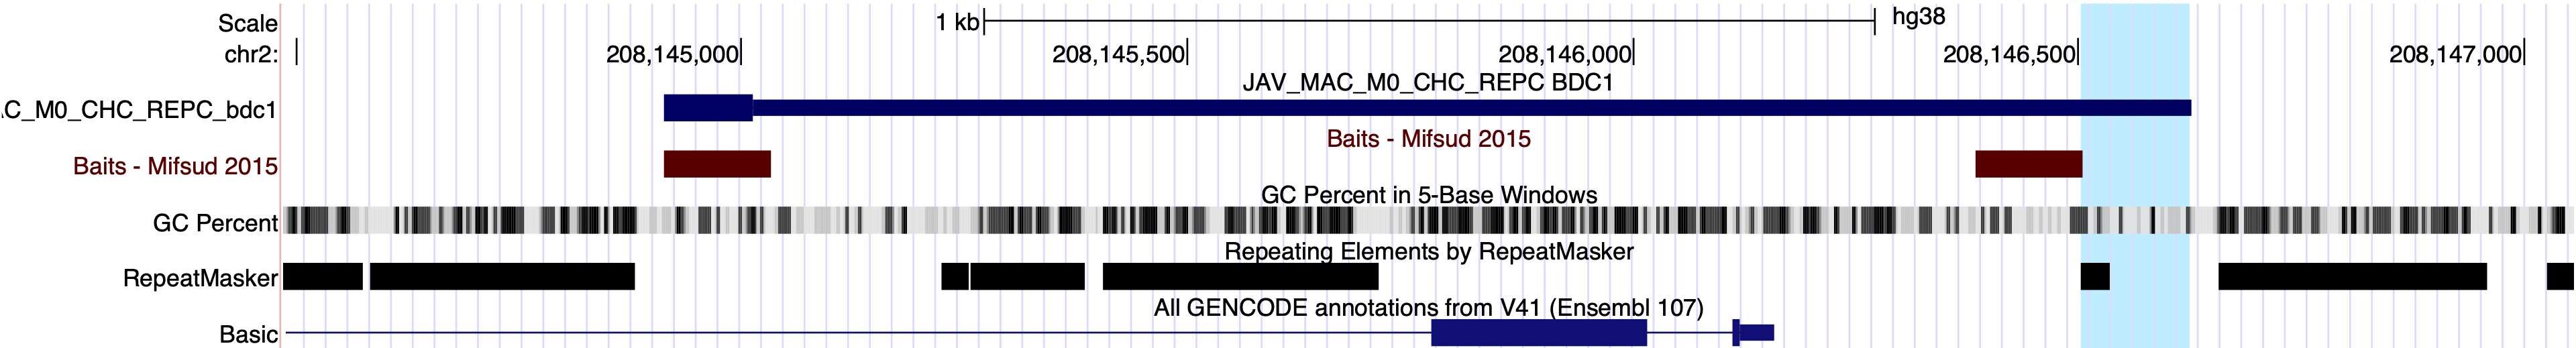

In [37]:
print("BDC1 example: chr2:208,144,486-208,147,056")
display.Image("../../docs/img/bdc1_shifted_bait_ucsc_example.png")

The opposite is the case for BDC2. Here, we find many examples where the 5' end bait is shifted.

BDC2 example: chr2:102,179,857-102,182,542


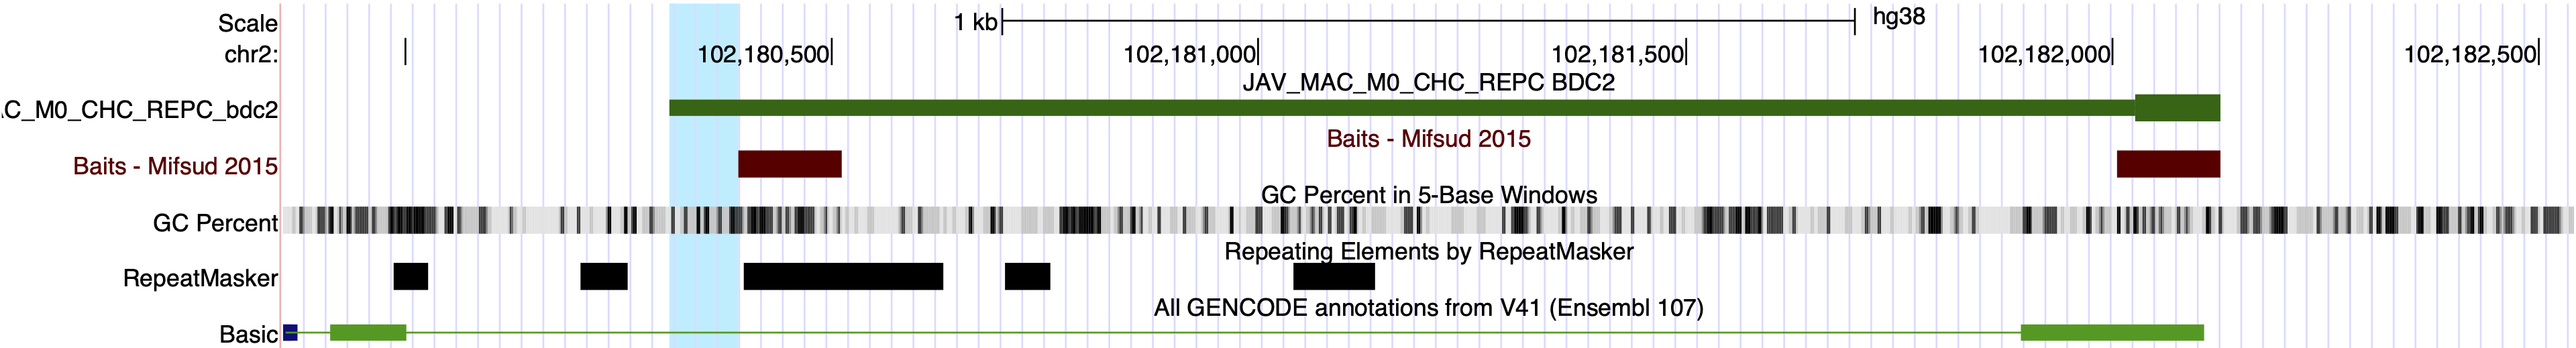

In [38]:
print("BDC2 example: chr2:102,179,857-102,182,542")
display.Image("../../docs/img/bdc2_shifted_bait_ucsc_example.png")

The following function determines the distances from the baits to digest ends.

```
5'-------------------3'
     -          -
  <->             <->
  d_5             d_3
               
```

In [39]:
def get_distances_between_baits_and_restriction_sites(d_coords: str, b5_coords: str, b3_coords: str):
    
    # Get relevant start and end coordinates of digest and baits
    d_sta = int(d_coords.split('\t')[1])
    d_end = int(d_coords.split('\t')[2])
    b5_sta = int(b5_coords.split('\t')[1])
    b3_end = int(b3_coords.split('\t')[2])
    
    # Calculate and return distances
    return b5_sta - d_sta, d_end - b3_end

First, we divide the baited digests into three groups:

1. `ONE_BAIT`: Baited digests with only one bait

2. `SHIFTED_BAITS`: Baited digests with two baits with one digest shifted by more than a specified maximum number of bases

3. `WELL_PLACED_BAITS`: All other digests with two baits

Given a `DIGESTS_WITH_BAITS_DICT` dictionary and a maximum allowed distance between baits and digest ends, the following function divides the baited digests into the three groups and returns three corresponding dictionaries of digests and a dictionary of counts for the various subgroups.

In [40]:
def subdivide_baited_digests_by_bait_characteristics(digest_with_baits_dict, max_dist=20):
    
    # Count digests in the various categories
    cnt_dict = {
        'BDC0': {'ONE_BAIT': 0, 'SHIFTED_BAITS': 0, 'WELL_PLACED_BAITS': 0},
        'BDC1': {'ONE_BAIT': 0, 'SHIFTED_BAITS': 0, 'WELL_PLACED_BAITS': 0},
        'BDC2': {'ONE_BAIT': 0, 'SHIFTED_BAITS': 0, 'WELL_PLACED_BAITS': 0},
    }
    
    # Dictionaries to be returned
    dwb_one_bait_dict = dict()
    dwb_shifted_baits_dict = dict()
    dwb_well_placed_baits_dict = dict()
    
    # Go through all baited digests
    for d_key in digest_with_baits_dict.keys():
        
        # Get baited digest class
        bd_class = 'BDC' + str(digest_with_baits_dict[d_key]['BDC'])
                        
        # Digest with only one bait
        if len(digest_with_baits_dict[d_key]['B5_COORDS'])!=1 or len(digest_with_baits_dict[d_key]['B3_COORDS'])!=1:
            dwb_one_bait_dict[d_key] = digest_with_baits_dict[d_key]
            cnt_dict[bd_class]['ONE_BAIT'] += 1
            continue
        
        # Get distances
        b5_dist, b3_dist = get_distances_between_baits_and_restriction_sites(
            d_coords = d_key,
            b5_coords = digest_with_baits_dict[d_key]['B5_COORDS'][0],
            b3_coords = digest_with_baits_dict[d_key]['B3_COORDS'][0])
        
        # Distinguish between digests with shifted and well-placed baits
        if b5_dist <= max_dist and b3_dist <= max_dist:
            dwb_well_placed_baits_dict[d_key] = digest_with_baits_dict[d_key]           
            cnt_dict[bd_class]['WELL_PLACED_BAITS'] += 1           
        else:
            dwb_shifted_baits_dict[d_key] = digest_with_baits_dict[d_key]
            cnt_dict[bd_class]['SHIFTED_BAITS'] += 1
                        
    return dwb_one_bait_dict, dwb_shifted_baits_dict, dwb_well_placed_baits_dict, cnt_dict

For the distance between bait and digest end, we allow a maximum of 20 bp.

In [41]:
MAX_DIST = 0
DWB_ONE_BAIT_DICT, DWB_SHIFTED_BAITS_DICT, DWB_WELL_PLACED_DICT, CNT_DICT = \
    subdivide_baited_digests_by_bait_characteristics(DIGESTS_WITH_BAITS_DICT, max_dist=MAX_DIST)

### Proportions of digests with shifted and well-placed baits

In [42]:
df = pd.DataFrame(data=CNT_DICT)
#print('Counts:')
#print(df)
df_pfc = df.div(df.sum(axis=0), axis=1).round(4)*100
#print('\nPercentages for columns:')
#print(df_pfc)
print('\nPercentages for rows:')
print(df_pfc.div(df_pfc.sum(axis=1), axis=0).round(4)*100)
print()
df_cwt = df.copy()
df_cwt.loc['Total'] = df_cwt.sum(numeric_only=True,axis=0)
df_cwt.loc[:,'Total'] = df_cwt.sum(numeric_only=True,axis=1)
print('Counts with totals:')
print(df_cwt)
print('\nPercentages for columns:')
total_col = df_cwt['Total']
total_col.drop("Total", axis=0, inplace=True)
df_pfc['Total'] = total_col.div(total_col.sum()).round(4)*100
print(df_pfc)


Percentages for rows:
                    BDC0   BDC1   BDC2
ONE_BAIT            1.41  53.42  45.17
SHIFTED_BAITS      15.76  44.62  39.63
WELL_PLACED_BAITS  39.38  29.48  31.14

Counts with totals:
                   BDC0  BDC1  BDC2  Total
ONE_BAIT             16   486   468    970
SHIFTED_BAITS       670  1544  1560   3774
WELL_PLACED_BAITS  7196  4384  5269  16849
Total              7882  6414  7297  21593

Percentages for columns:
                   BDC0   BDC1   BDC2  Total
ONE_BAIT            0.2   7.58   6.41   4.49
SHIFTED_BAITS       8.5  24.07  21.38  17.48
WELL_PLACED_BAITS  91.3  68.35  72.21  78.03


Create LaTeX table.

In [43]:
df_cwt.rename(index={"ONE_BAIT": "I. At only one end", "SHIFTED_BAITS": "II. Shifted", "WELL_PLACED_BAITS": "III. Well placed"}, inplace=True)
df_pfc.rename(index={"ONE_BAIT": "I. At only one end", "SHIFTED_BAITS": "II. Shifted", "WELL_PLACED_BAITS": "III. Well placed"}, inplace=True)
print("\\begin{tabular}{l|rr|rr|rr|rr}")
print("\t\\multicolumn{9}{l}{{\\bf A:} Fragments with baits at only one end, shifted baits and well placed baits}" + "\\" + "\\" + "\\hline")
print("\t& {\\bf BDC0}& & {\\bf BDC1}& & {\\bf BDC2}& & {\\bf Total}" + "\\" + "\\" + "\\hline")
for i in ['I. At only one end', 'II. Shifted', 'III. Well placed', 'Total']:
    row = "\t{\\bf " + i.replace("_", " ") + "}"
    for j in ['BDC0', 'BDC1', 'BDC2', 'Total']:
        row += "& " + "{:,}".format(df_cwt[j][i])
        if i != 'Total':
            row += "& " + str(int(round(df_pfc[j][i]))) + "\%"
        else:
            if j != 'Total':
                row += "& "
    row += "\\" + "\\"
    if i == 'III. Well placed' or i == 'Total':
        row += "\\hline"
    print(row)
print("\\end{tabular}")

\begin{tabular}{l|rr|rr|rr|rr}
	\multicolumn{9}{l}{{\bf A:} Fragments with baits at only one end, shifted baits and well placed baits}\\\hline
	& {\bf BDC0}& & {\bf BDC1}& & {\bf BDC2}& & {\bf Total}\\\hline
	{\bf I. At only one end}& 16& 0\%& 486& 8\%& 468& 6\%& 970& 4\%\\
	{\bf II. Shifted}& 670& 8\%& 1,544& 24\%& 1,560& 21\%& 3,774& 17\%\\
	{\bf III. Well placed}& 7,196& 91\%& 4,384& 68\%& 5,269& 72\%& 16,849& 78\%\\\hline
	{\bf Total}& 7,882& & 6,414& & 7,297& & 21,593\\\hline
\end{tabular}


Prepare contingency table for a Fisher's exact test. For this test, we only consider digests with baits on both sides and combine the counts for BDC1 and BDC2 digests.

In [44]:
df_cont = pd.DataFrame(data=CNT_DICT)
df_cont = df_cont.drop("ONE_BAIT", axis=0, inplace=False)
df_cont['BDC12'] = df_cont['BDC1'] + df_cont['BDC2']
df_cont = df_cont.drop(["BDC1", "BDC2"], axis=1, inplace=False)
print('Counts:')
print(df_cont)
print('\nPercentages for columns:')
print(df_cont.div(df_cont.sum(axis=0), axis=1).round(4)*100)
print('\nPercentages for rows:')
print(df_cont.div(df_cont.sum(axis=1), axis=0).round(4)*100)

Counts:
                   BDC0  BDC12
SHIFTED_BAITS       670   3104
WELL_PLACED_BAITS  7196   9653

Percentages for columns:
                    BDC0  BDC12
SHIFTED_BAITS       8.52  24.33
WELL_PLACED_BAITS  91.48  75.67

Percentages for rows:
                    BDC0  BDC12
SHIFTED_BAITS      17.75  82.25
WELL_PLACED_BAITS  42.71  57.29


Perform a Fisher's exact test on this contingency table.

In [45]:
contingency_table = [
    [df_cont['BDC0']['SHIFTED_BAITS'], df_cont['BDC12']['SHIFTED_BAITS']],
    [df_cont['BDC0']['WELL_PLACED_BAITS'], df_cont['BDC12']['WELL_PLACED_BAITS']]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 0.2895504482730956
P-value: 1.6295021896170203e-195


Create LaTeX table.

In [46]:
df_latex_cnt = pd.DataFrame(data=CNT_DICT)
df_latex_cnt.rename(index={"SHIFTED_BAITS": "II. Shifted", "WELL_PLACED_BAITS": "III. Well placed"}, inplace=True)
df_latex_cnt = df_latex_cnt.drop("ONE_BAIT", axis=0, inplace=False)
df_latex_cnt['BDC12'] = df_latex_cnt['BDC1'] + df_latex_cnt['BDC2']
df_latex_cnt = df_latex_cnt.drop(["BDC1", "BDC2"], axis=1, inplace=False)
df_latex_cnt.loc[:,'Total'] = df_latex_cnt.sum(numeric_only=True,axis=1)
df_latex_pct = df_latex_cnt.div(df_latex_cnt.sum(axis=0), axis=1).round(4)*100
df_latex_cnt.loc['Total'] = df_latex_cnt.sum(numeric_only=True,axis=0)
print("\\begin{tabular}{l|rr|rr|rr}")
print("\t\\multicolumn{6}{l}{{\\bf D:} Fragments with shifted baits and well placed baits}" + "\\" + "\\" + "\\hline")
print("\t& {\\bf BDC0}& & {\\bf BDC12}& & {\\bf Total}" + "\\" + "\\" + "\\hline")
for i in ['II. Shifted', 'III. Well placed', 'Total']:
    row = "\t{\\bf " + i.replace("_", " ") + "}"
    for j in ['BDC0', 'BDC12', 'Total']:
        row += "& " + "{:,}".format(df_latex_cnt[j][i])
        if i != 'Total':
            row += "& " + str(int(round(df_latex_pct[j][i]))) + "\%"
        else:
            if j != 'Total':
                row += "& "
    row += "\\" + "\\"
    if i == 'III. Well placed' or i == 'Total':
        row += "\\hline"
    print(row)
print("\\end{tabular}")

\begin{tabular}{l|rr|rr|rr}
	\multicolumn{6}{l}{{\bf D:} Fragments with shifted baits and well placed baits}\\\hline
	& {\bf BDC0}& & {\bf BDC12}& & {\bf Total}\\\hline
	{\bf II. Shifted}& 670& 9\%& 3,104& 24\%& 3,774& 18\%\\
	{\bf III. Well placed}& 7,196& 91\%& 9,653& 76\%& 16,849& 82\%\\\hline
	{\bf Total}& 7,866& & 12,757& & 20,623\\\hline
\end{tabular}


### Distributions of distances between baits and digest ends

In [47]:
def get_lists_with_distances(dwb_on_both_sides_dict, bd_classes=[0,1,2]):
    
    # Lists with distances between baits and digest ends
    b5_dist_list = []
    b3_dist_list = []
    
    # Go through all baited digests
    for d_key in dwb_on_both_sides_dict.keys():
        
        # Filter for digests with specified baited digest classes
        if dwb_on_both_sides_dict[d_key]['BDC'] not in bd_classes:
            continue
        
        # Skip digests with only one bait
        if len(dwb_on_both_sides_dict[d_key]['B5_COORDS'])!=1 or len(dwb_on_both_sides_dict[d_key]['B3_COORDS'])!=1:
            print('[WARNING]: The digest is skipped because has a bait on only one side!')
            continue
        
        # Get distances
        b5_dist, b3_dist = get_distances_between_baits_and_restriction_sites(
            d_coords = d_key,
            b5_coords = dwb_on_both_sides_dict[d_key]['B5_COORDS'][0],
            b3_coords = dwb_on_both_sides_dict[d_key]['B3_COORDS'][0])
        b5_dist_list.append(b5_dist)
        b3_dist_list.append(b3_dist)
        
    return b5_dist_list, b3_dist_list

The following function creates a plot in which the distributions of distances are shown in a special layout. We will reuse this function later for the analysises of GC of  bait sequences.

In [48]:
def create_bdc_boxplot(
    bdc0_b5=None, # BDC0 5' bait
    bdc0_b3=None, # BDC0 3' bait
    bdc1_b5=None, # BDC1 5' bait
    bdc1_b3=None, # BDC1 3' bait
    bdc2_b5=None, # BDC2 5' bait
    bdc2_b3=None, # BDC2 3' bait
    showfliers = True,
    title='TITEL',
    xlabel_l='XLAB_L',
    xlabel_r='XLAB_R',
    output_pdf='OUT.pdf'):

    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1,2)
    box_width = 0.5
    ax1.set_title(title, loc='left')
    
    # Determine range to be displayed    
    xmin = min(bdc0_b5 + bdc0_b3  + bdc1_b5 + bdc1_b3 + bdc2_b5 + bdc2_b3)
    xmax = max(bdc0_b5 + bdc0_b3  + bdc1_b5 + bdc1_b3 + bdc2_b5 + bdc2_b3)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding        

    # Create boxplots for 5' baits (left)
    bp1 = ax1.boxplot(
        [bdc2_b5, bdc1_b5, bdc0_b5],
        widths=(box_width, box_width, box_width),
        patch_artist=True,
        labels=['BFC2\nn=' + '{:,}'.format(len(bdc2_b5)),
                'BFC1\nn=' + '{:,}'.format(len(bdc1_b5)),
                'BFC0\nn=' + '{:,}'.format(len(bdc0_b5))],
        vert=False,
        showfliers=showfliers
    )
    colors = ['green', 'blue', 'gray']
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    ax1.set_xlabel(xlabel_l)
    
    # Highlight the area between the first and the third quantiles of the 5' distances of BDC0 in gray
    shaded_q1, shaded_q2, shaded_q3 = quantile(bdc0_b5, [0.25, 0.50, 0.75])
    ax1.axvspan(shaded_q1, shaded_q3, facecolor='gray', alpha=0.2)
    ax1.axvline(shaded_q2, color='lightgray', zorder=0)

    # Create boxplots for 3' baits (right)
    x = ax2.boxplot(
        [bdc2_b3, bdc1_b3, bdc0_b3],
        widths=(box_width, box_width, box_width),
        patch_artist=True,
        vert=False,
        showfliers=showfliers
    )
    colors = ['green', 'blue', 'gray']
    for patch, color in zip(x['boxes'], colors):
        patch.set_facecolor(color)
    ax2.set_xlabel(xlabel_r)
    
    # Hide tick labels
    [t.set_color('white') for t in ax2.yaxis.get_ticklabels()]
    
    # Highlight the area between the first and the third quantiles of the 5' distances of BDC0 in gray
    shaded_q1, shaded_q2, shaded_q3 = quantile(bdc0_b3, [0.25, 0.50, 0.75])
    ax2.axvspan(shaded_q1, shaded_q3, facecolor='gray', alpha=0.2)
    ax2.axvline(shaded_q2, color='lightgray', zorder=0)

    # Set limits of the x-axes
    #if showfliers is False:
    xmin_1, xmax_1 = ax1.get_xlim()
    xmin_2, xmax_2 = ax2.get_xlim()
    xmin = min([xmin_1, xmax_1, xmin_2, xmax_2])
    xmax = max([xmin_1, xmax_1, xmin_2, xmax_2])
    ax1.set_xlim(xmin,xmax)
    ax2.set_xlim(xmin,xmax)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding

    # Format figure and write to PDF file
    fig.set_figheight(3)
    fig.set_figwidth(8.5)#7.5
    fig.tight_layout()
    fig.savefig(output_pdf)

We apply the function to the different baited digest classes. For each function call, we get two lists with distances.

In [49]:
BDC0_B5_DIST_LIST, BDC0_B3_DIST_LIST = get_lists_with_distances(
    dwb_on_both_sides_dict=DWB_SHIFTED_BAITS_DICT,
    bd_classes=[0])

BDC1_B5_DIST_LIST, BDC1_B3_DIST_LIST = get_lists_with_distances(
    dwb_on_both_sides_dict=DWB_SHIFTED_BAITS_DICT,
    bd_classes=[1])

BDC2_B5_DIST_LIST, BDC2_B3_DIST_LIST = get_lists_with_distances(
    dwb_on_both_sides_dict=DWB_SHIFTED_BAITS_DICT,
    bd_classes=[2])

Now we apply the plot funtion to all lists with distances at once.

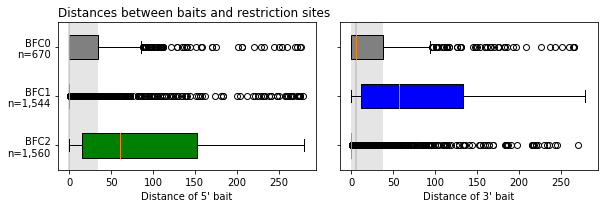

In [50]:
create_bdc_boxplot(
    bdc0_b5=BDC0_B5_DIST_LIST,
    bdc0_b3=BDC0_B3_DIST_LIST,
    bdc1_b5=BDC1_B5_DIST_LIST,
    bdc1_b3=BDC1_B3_DIST_LIST,
    bdc2_b5=BDC2_B5_DIST_LIST,
    bdc2_b3=BDC2_B3_DIST_LIST,
    showfliers=True,
    title='Distances between baits and restriction sites',
    xlabel_l='Distance of 5\' bait',
    xlabel_r='Distance of 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distances_between_baits_and_restriction_sites.pdf')

On the left are the boxplots for the distances of the `5'` baits and on the right the boxplots for the distances of the `3'` baits. The top boxplots (gray) show the distributions of distances for baited digests of the class BDC0. The range between the first and third quantile is highlighted in lightgray. Below the boxplots for BDC0, the boxplots for BDC1 (blue) and BDC2 (green) are shown.

The boxplots above show the distributions of `5'` and `3'` baits independently. In fact, however, we have a pair of distances for each digest. The following lines of code calculate the differences in distances for each pair.

In [37]:
# Get lists with differences for distances
BDC0_DIFF_DIST_LIST = [x[0]-x[1] for x in zip(BDC0_B5_DIST_LIST, BDC0_B3_DIST_LIST)]
BDC1_DIFF_DIST_LIST = [x[0]-x[1] for x in zip(BDC1_B5_DIST_LIST, BDC1_B3_DIST_LIST)]
BDC2_DIFF_DIST_LIST = [x[0]-x[1] for x in zip(BDC2_B5_DIST_LIST, BDC2_B3_DIST_LIST)]

We use the same plot function as before, but this time, for each baited digest class, we pass the same list of differences for `5'` and `3'` baits. This results in two identical plots. This way we can reuse the plot function.

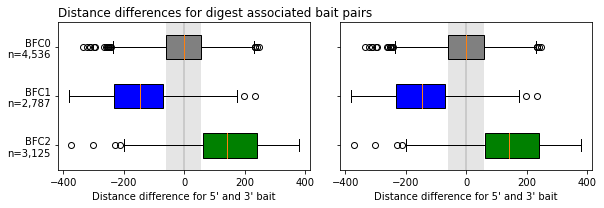

In [38]:
create_bdc_boxplot(
    bdc0_b5=BDC0_DIFF_DIST_LIST,
    bdc0_b3=BDC0_DIFF_DIST_LIST,
    bdc1_b5=BDC1_DIFF_DIST_LIST,
    bdc1_b3=BDC1_DIFF_DIST_LIST,
    bdc2_b5=BDC2_DIFF_DIST_LIST,
    bdc2_b3=BDC2_DIFF_DIST_LIST,
    showfliers = True,
    title='Distance differences for digest associated bait pairs',
    xlabel_l='Distance difference for 5\' and 3\' bait',
    xlabel_r='Distance difference for 5\' and 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distance_differences_for_digest_associated_bait_pairs.pdf')

To assess the deviations from zero for statistical significance, we use the non-parametric Wilcoxon signed rank test.

In [39]:
print(stats.wilcoxon(BDC0_DIFF_DIST_LIST))
print(stats.wilcoxon(BDC1_DIFF_DIST_LIST))
print(stats.wilcoxon(BDC2_DIFF_DIST_LIST))

WilcoxonResult(statistic=5037633.5, pvalue=0.2756821267810635)
WilcoxonResult(statistic=142096.5, pvalue=0.0)
WilcoxonResult(statistic=214694.5, pvalue=0.0)


## Digest with baits on both sides but neither bait is shifted towards the center

First, we create a dictionary from which the sequences of baits can be retrieved via their coordinates.

In [40]:
BAIT_SEQ_dict = dict()
OUT_PREFIX
BAIT_FILE.sequence(fi=GENOME_FILE, fo=NOTEBOOK_RESULTS_DIR + '/bait_sequences.fa', tab=True)
with open(NOTEBOOK_RESULTS_DIR + '/bait_sequences.fa', 'rt') as fp:
    for line in fp:
        coords, seq = line.rstrip().split('\t')
        chrom = coords.split(':')[0]
        sta = coords.split(':')[1].split('-')[0]
        end = coords.split(':')[1].split('-')[1]
        BAIT_SEQ_dict[chrom + '\t' + sta + '\t' + end] = seq

I addition, we define a function that that returns the GC of a given DNA sequence.

In [41]:
def get_gc_content(sequence):
    
    # Determine GC content
    GC_count = sequence.count('g')
    GC_count += sequence.count('G')
    GC_count += sequence.count('c')
    GC_count += sequence.count('C')
    seq_len = len(sequence)
    gc_content = GC_count/seq_len
    
    return gc_content

Here is a function call to illustrate how it works.

In [42]:
get_gc_content('NtacgCGCGC')

0.7

A digest dictionary with well placed baits is passed to the following function. For each digest, the GC contents of the two baits are determined and appended to lists that are returned at the end.

In [43]:
def get_gc_content_of_baits(dwb_well_placed_dict, bd_classes=[0,1,2]):
    b5_gc_list = []
    b3_gc_list = []
    for d_key in dwb_well_placed_dict.keys():
    
        # Filter for digests with specified baited digest classes
        if dwb_well_placed_dict[d_key]['BDC'] not in bd_classes:
            continue

        # Get GC content of 5' bait
        seq = BAIT_SEQ_dict[dwb_well_placed_dict[d_key]['B5_COORDS'][0]]
        gc_content = get_gc_content(seq)
        b5_gc_list.append(gc_content)

        # Get GC content of 3' bait
        seq = BAIT_SEQ_dict[dwb_well_placed_dict[d_key]['B3_COORDS'][0]]
        gc_content = get_gc_content(seq)
        b3_gc_list.append(gc_content)
        
    return b5_gc_list, b3_gc_list

We use this funtion to generate separate lists with GC and repeat contents for the baited digests of the different classes.

In [44]:
BDC0_B5_GC_LIST, BDC0_B3_GC_LIST = get_gc_content_of_baits(
    DWB_WELL_PLACED_DICT,
    bd_classes=[0])

BDC1_B5_GC_LIST, BDC1_B3_GC_LIST = get_gc_content_of_baits(
    DWB_WELL_PLACED_DICT,
    bd_classes=[1])

BDC2_B5_GC_LIST, BDC2_B3_GC_LIST = get_gc_content_of_baits(
    DWB_WELL_PLACED_DICT,
    bd_classes=[2])

Then we use our boxplot function to compare the distributions of GC contents.

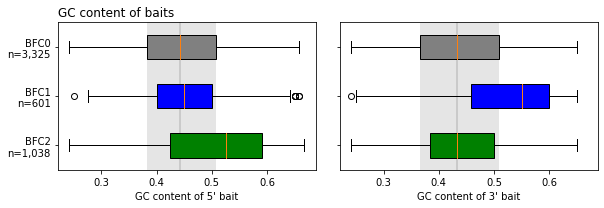

In [45]:
create_bdc_boxplot(
    bdc0_b5=BDC0_B5_GC_LIST,
    bdc0_b3=BDC0_B3_GC_LIST,
    bdc1_b5=BDC1_B5_GC_LIST,
    bdc1_b3=BDC1_B3_GC_LIST,
    bdc2_b5=BDC2_B5_GC_LIST,
    bdc2_b3=BDC2_B3_GC_LIST,
    showfliers=True,
    title='GC content of baits',
    xlabel_l='GC content of 5\' bait',
    xlabel_r='GC content of 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits.pdf')

Get lists with differences for GC content.

In [46]:
BDC0_DIFF_GC_LIST = [x[0]-x[1] for x in zip(BDC0_B5_GC_LIST, BDC0_B3_GC_LIST)]
BDC1_DIFF_GC_LIST = [x[0]-x[1] for x in zip(BDC1_B5_GC_LIST, BDC1_B3_GC_LIST)]
BDC2_DIFF_GC_LIST = [x[0]-x[1] for x in zip(BDC2_B5_GC_LIST, BDC2_B3_GC_LIST)]

Then we use our boxplot function to visualize the distributions of differences. Remember that in this case the boxplots on the left and right are identical.

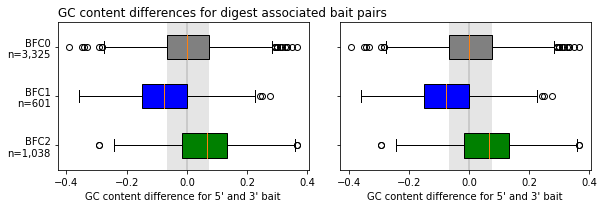

In [47]:
create_bdc_boxplot(
    bdc0_b5=BDC0_DIFF_GC_LIST,
    bdc0_b3=BDC0_DIFF_GC_LIST,
    bdc1_b5=BDC1_DIFF_GC_LIST,
    bdc1_b3=BDC1_DIFF_GC_LIST,
    bdc2_b5=BDC2_DIFF_GC_LIST,
    bdc2_b3=BDC2_DIFF_GC_LIST,
    showfliers = True,
    title='GC content differences for digest associated bait pairs',
    xlabel_l='GC content difference for 5\' and 3\' bait',
    xlabel_r='GC content difference for 5\' and 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_digest_associated_bait_pairs.pdf')

If the differences are evenly distributed around zero, this means that the GC content of the bait pairs is independent of the `5'` and `3'` direction. If the differences are shifted towards negative differences, then this means that there are many bait pairs where the GC content of the `3'` bait is higher than that of the `5'` bait. If the differences are shifted towards positive differences, then this means that there are many bait pairs where the GC content of the `5'` bait is higher than that of the `3'` bait.

We test the deviations from zero for statistical significance using a Wilcoxon signed-rank test.

In [48]:
print(stats.wilcoxon(BDC0_DIFF_GC_LIST))
print(stats.wilcoxon(BDC1_DIFF_GC_LIST))
print(stats.wilcoxon(BDC2_DIFF_GC_LIST))

WilcoxonResult(statistic=2505741.5, pvalue=0.09847498163586947)
WilcoxonResult(statistic=34126.5, pvalue=1.8243267866682622e-36)
WilcoxonResult(statistic=106299.0, pvalue=6.009119281543419e-59)


### Repeat content

In [49]:
def get_repeat_content(sequence):
    
    # Determine repeat content
    sequence = sub("[a-z]", 'R', sequence)
    R_count = sequence.count('R')
    seq_len = len(sequence)
    repeat_content = R_count/seq_len
    
    return repeat_content

In [50]:
get_repeat_content('NtacgCGCGC')

0.4

In [51]:
def get_repeat_content_of_baits(dwb_well_placed_dict, bd_classes=[0,1,2]):
    b5_repeat_list = []
    b3_repeat_list = []
    for d_key in dwb_well_placed_dict.keys():
    
        # Filter for digests with specified baited digest classes
        if dwb_well_placed_dict[d_key]['BDC'] not in bd_classes:
            continue

        # Get repeat content of 5' bait
        seq = BAIT_SEQ_dict[dwb_well_placed_dict[d_key]['B5_COORDS'][0]]
        repeat_content = get_repeat_content(seq)
        b5_repeat_list.append(repeat_content)

        # Get repeat content of 3' bait
        seq = BAIT_SEQ_dict[dwb_well_placed_dict[d_key]['B3_COORDS'][0]]
        repeat_content = get_repeat_content(seq)
        b3_repeat_list.append(repeat_content)
        
    return b5_repeat_list, b3_repeat_list

In [52]:
BDC0_B5_REPEAT_LIST, BDC0_B3_REPEAT_LIST = get_repeat_content_of_baits(
    DWB_WELL_PLACED_DICT,
    bd_classes=[0])

BDC1_B5_REPEAT_LIST, BDC1_B3_REPEAT_LIST = get_repeat_content_of_baits(
    DWB_WELL_PLACED_DICT,
    bd_classes=[1])

BDC2_B5_REPEAT_LIST, BDC2_B3_REPEAT_LIST = get_repeat_content_of_baits(
    DWB_WELL_PLACED_DICT,
    bd_classes=[2])

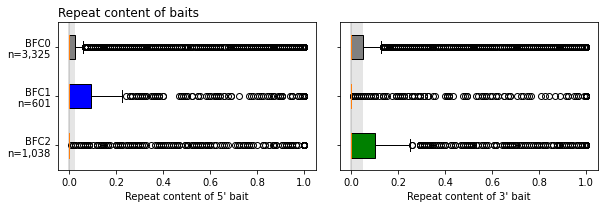

In [53]:
create_bdc_boxplot(
    bdc0_b5=BDC0_B5_REPEAT_LIST,
    bdc0_b3=BDC0_B3_REPEAT_LIST,
    bdc1_b5=BDC1_B5_REPEAT_LIST,
    bdc1_b3=BDC1_B3_REPEAT_LIST,
    bdc2_b5=BDC2_B5_REPEAT_LIST,
    bdc2_b3=BDC2_B3_REPEAT_LIST,
    showfliers=True,
    title='Repeat content of baits',
    xlabel_l='Repeat content of 5\' bait',
    xlabel_r='Repeat content of 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits.pdf')

In [54]:
BDC0_DIFF_REPEAT_LIST = [x[0]-x[1] for x in zip(BDC0_B5_REPEAT_LIST, BDC0_B3_REPEAT_LIST)]
BDC1_DIFF_REPEAT_LIST = [x[0]-x[1] for x in zip(BDC1_B5_REPEAT_LIST, BDC1_B3_REPEAT_LIST)]
BDC2_DIFF_REPEAT_LIST = [x[0]-x[1] for x in zip(BDC2_B5_REPEAT_LIST, BDC2_B3_REPEAT_LIST)]

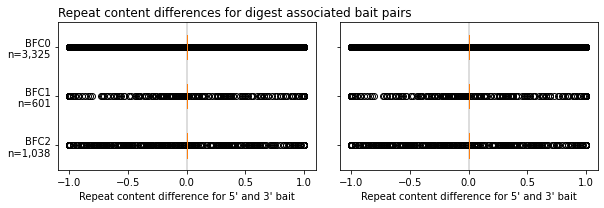

In [55]:
create_bdc_boxplot(
    bdc0_b5=BDC0_DIFF_REPEAT_LIST,
    bdc0_b3=BDC0_DIFF_REPEAT_LIST,
    bdc1_b5=BDC1_DIFF_REPEAT_LIST,
    bdc1_b3=BDC1_DIFF_REPEAT_LIST,
    bdc2_b5=BDC2_DIFF_REPEAT_LIST,
    bdc2_b3=BDC2_DIFF_REPEAT_LIST,
    showfliers = True,
    title='Repeat content differences for digest associated bait pairs',
    xlabel_l='Repeat content difference for 5\' and 3\' bait',
    xlabel_r='Repeat content difference for 5\' and 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_digest_associated_bait_pairs.pdf')

In [56]:
print(stats.wilcoxon(BDC0_DIFF_REPEAT_LIST))
print(stats.wilcoxon(BDC1_DIFF_REPEAT_LIST))
print(stats.wilcoxon(BDC2_DIFF_REPEAT_LIST))

WilcoxonResult(statistic=520781.5, pvalue=0.8484377657753714)
WilcoxonResult(statistic=14307.5, pvalue=0.0059552159023769915)
WilcoxonResult(statistic=34849.5, pvalue=0.00016615133461777407)


In [57]:
def get_zero_prop(repc_list):
    n = len(repc_list)
    n_zero = repc_list.count(0.0)
    p_zero = n_zero/n
    return p_zero

In [58]:
print('Numbers of zeros')
print('BDC0-B5: ' + str(get_zero_prop(BDC0_B5_REPEAT_LIST)))
print('BDC0-B3: ' + str(get_zero_prop(BDC0_B3_REPEAT_LIST)))
print('BDC1-B5: ' + str(get_zero_prop(BDC1_B5_REPEAT_LIST)))
print('BDC1-B3: ' + str(get_zero_prop(BDC1_B3_REPEAT_LIST)))
print('BDC2-B5: ' + str(get_zero_prop(BDC2_B5_REPEAT_LIST)))
print('BDC2-B3: ' + str(get_zero_prop(BDC2_B3_REPEAT_LIST)))

Numbers of zeros
BDC0-B5: 0.7425563909774436
BDC0-B3: 0.7365413533834586
BDC1-B5: 0.7271214642262895
BDC1-B3: 0.7670549084858569
BDC2-B5: 0.7880539499036608
BDC2-B3: 0.7312138728323699


In [59]:
import numpy as np
print('Mean repeat contents')
print('BDC0-B5: ' + str(np.mean(BDC0_B5_REPEAT_LIST)))
print('BDC0-B3: ' + str(np.mean(BDC0_B3_REPEAT_LIST)))
print('BDC1-B5: ' + str(np.mean(BDC1_B5_REPEAT_LIST)))
print('BDC1-B3: ' + str(np.mean(BDC1_B3_REPEAT_LIST)))
print('BDC2-B5: ' + str(np.mean(BDC2_B5_REPEAT_LIST)))
print('BDC2-B3: ' + str(np.mean(BDC2_B3_REPEAT_LIST)))

Mean repeat contents
BDC0-B5: 0.16406339619540655
BDC0-B3: 0.16399498746867167
BDC1-B5: 0.17414032168607876
BDC1-B3: 0.12339156960621186
BDC2-B5: 0.12630860629415544
BDC2-B3: 0.17671001926782273
